In [24]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset,DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

In [16]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

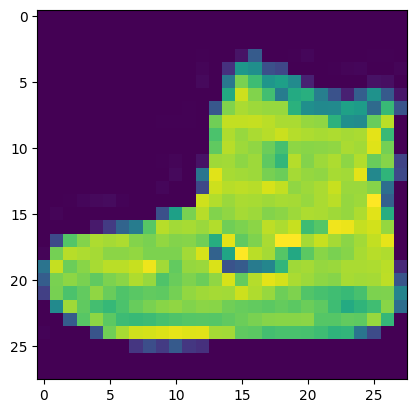

In [50]:
plt.imshow(training_data[0][0].squeeze())

In [13]:
train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

In [65]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(16, 8, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 1, 
                               kernel_size=3, 
                               stride=2, 
                               padding=1, 
                               output_padding=1),
            nn.Sigmoid()
        )
         
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [66]:
model = Autoencoder()
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [67]:
model.to('cuda')

Autoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (1): ReLU()
    (2): ConvTranspose2d(16, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (3): Sigmoid()
  )
)

In [68]:
num_epochs = 50
for epoch in range(num_epochs):
    for data in train_dataloader:
        img, _ = data
        img = img.to('cuda')
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, img)
        loss.backward()
        optimizer.step()
    if epoch % 5== 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [1/50], Loss: 0.0121
Epoch [6/50], Loss: 0.0098
Epoch [11/50], Loss: 0.0070
Epoch [16/50], Loss: 0.0069
Epoch [21/50], Loss: 0.0080
Epoch [26/50], Loss: 0.0057
Epoch [31/50], Loss: 0.0050
Epoch [36/50], Loss: 0.0059
Epoch [41/50], Loss: 0.0054
Epoch [46/50], Loss: 0.0063


In [357]:
from sklearn.manifold import TSNE
import plotly.express as px

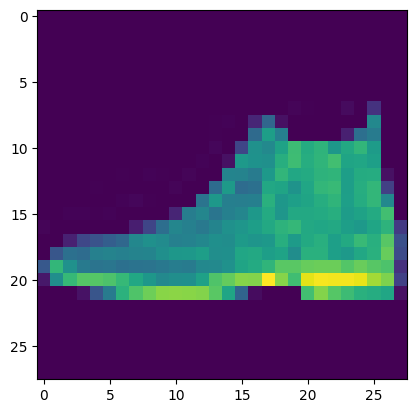

In [134]:
num_correct = 0
num_samples = 0
model.eval()
with torch.no_grad():
        for data in test_dataloader:
            img,_ =data
            img = img.to('cuda')
            recon = model(img)
            break
x = recon[1].to('cpu')
plt.imshow(x.squeeze())

# plt.imshow(test_data[0][0].squeeze())

In [310]:
label = []
for img,lbl in test_data:
  label.append(lbl)

label_set = set(label)
label_set

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

In [262]:
data = []

for i in test_data:
    with torch.no_grad():
        x = i[0].to('cuda')
        t = model.encoder(x)
        data.append(t)

In [265]:
for i in range(len(data)):
    data[i] = data[i].cpu()

data = np.array(data)

In [267]:
features = []
for i in range(len(data)):
   features.append(np.reshape(data[i],392))

In [271]:
features = np.array(features)

In [354]:
cmap = plt.cm.Spectral
norm = plt.Normalize(vmin=0, vmax=9)
x = cmap(norm(label))
label_color = {}


array([[0.36862745, 0.30980392, 0.63529412, 1.        ],
       [0.96378316, 0.47743176, 0.28581315, 1.        ],
       [0.84721261, 0.26120723, 0.30519031, 1.        ],
       ...,
       [0.21607074, 0.55563245, 0.73194925, 1.        ],
       [0.84721261, 0.26120723, 0.30519031, 1.        ],
       [0.94425221, 0.97770088, 0.66205306, 1.        ]])

In [358]:
tsne_model = TSNE()

transformed = tsne_model.fit_transform(features)

df = pd.DataFrame(transformed,columns=['x','y'])
df['label'] = label

fig = px.scatter(df,x='x',y='y',color='label')
fig.show()
